In [1]:
import tensorflow as tf
import chess
import chess.engine
import random
import cupy as np
import numpy
import tensorflow as tf


# this function will create our x (board)
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board


# this function will create our f(x) (score)
def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci('A:\\chess\\Chess-AI-with-TensorFlow\\stockfish\\13\\bin\\stockfish_20011801_x64.exe') as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

A:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6



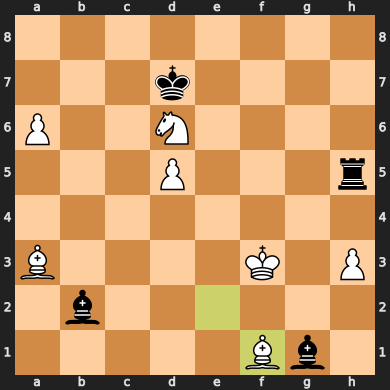

In [3]:
board = random_board()
board

In [4]:
print(stockfish(board, 15))

-324


The Idea is that the Deep Learning Network will predict this score based on the positions of the pieces on the board.

# Creating the dataset

Now we need to convert the board representation to something meaningful.
A 3d matrix of sizes **8 x 8 x 14** where 8x8 repersents the board and the 14 represents the 7 different pieces 

In [5]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}


# example: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]


def split_dims(board):
  # this is the 3d matrix
  board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

  # here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add attacks and valid moves too
  # so the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d

In [6]:
t = split_dims(board)
t.shape

(14, 8, 8)

Now, all we have to do is call **random_board()** to create random boards, **stockfish()** to get a score for how good each board is for white.

Then we convert each board to a 3d matrix using **split_dims()**, now creating the dataset is easy!

# TensorFlow!

In [7]:
#import tensorflow.keras
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers


def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

Skip connections (residual network) will likely improve the model for deeper connections. If you want to test the residual model, check the code below.

In [8]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(200, 'relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(200, 'relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(200, 'relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

In [9]:
model = build_model_residual(32, 4)

# It's training time!

In [10]:
import tensorflow.keras.callbacks as callbacks
from sklearn.model_selection import train_test_split

def get_dataset():
	container = numpy.load('dataset.npz')
	b, v = container['b'], container['v']
	v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1) #should we be normalizing. 
	return b, v


boardstates, evaluation  = get_dataset()
x_train, x_test, y_train, y_test = train_test_split(boardstates, evaluation, test_size = 0.2, random_state = random.randint(1, 9999))
x_train.transpose()
print(x_train.shape)
print(y_train.shape)

(1200000, 14, 8, 8)
(1200000,)


In [11]:
y_train

array([0.5110508 , 0.46498895, 0.39833233, ..., 0.4532851 , 0.45464134,
       0.45830822], dtype=float32)

In [12]:
x = numpy.empty(10)
y = numpy.empty(10)
numpy.savez('test.npz', x, y)
container = numpy.load('test.npz')
container.files
a = container['arr_0']
a.size

10

In [13]:
def createData(NumberOfTrainings):
    outfile = 'chessdata1.npz'
    xdata = numpy.empty([NumberOfTrainings, 14,8,8])
    ylables = numpy.empty(NumberOfTrainings)
    for i in range(NumberOfTrainings):
        if(i%10000 == 0):
            numpy.savez(outfile, xdata, ylables)
            print(i)
        board = random_board()
        y = (stockfish(board, 15))  
        x = split_dims(board)
        ylables[i] = y
        xdata[i] = x
    numpy.savez(outfile, xdata, ylables)
    return xdata, ylables
#x_temp, y_temp = createData(250000)
#print(x_temp.shape)
#print(y_temp.shape)
container = numpy.load('chessdata1.npz')
x_test2 = container['arr_0']
y_test2 = container['arr_1']

In [14]:
print(x_test2.shape)
print(y_test2.shape)
print(y_test2[800]) #the ytest2 will be 0 if there is no data in it 

(250000, 14, 8, 8)
(250000,)
1365.0


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])
model.summary()
checkpoint_filepath = '\\tmp\\checkpoint\\'
model_checkpointing_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only= True,
)
history = model.fit(x_train, y_train,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4),model_checkpointing_callback])

model.save('modeltest.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 8, 8)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 8, 32)    2336        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 8, 32)    9248        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 8, 32)   128         ['conv2d_1[0][0]']               
 alization)                                                                                   

 dropout_1 (Dropout)            (None, 200)          0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 200)          40200       ['dropout_1[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 200)          0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 1)            201         ['dropout_2[0][0]']              
                                                                                                  
Total params: 874,945
Trainable params: 874,433
Non-trainable params: 512
__________________________________________________________________________________________________
Epoch 1/1000
527/528 [=============

INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


528/528 [==============================] - 28s 43ms/step - loss: 0.0050 - mae: 0.0479 - mse: 0.0050 - val_loss: 0.0041 - val_mae: 0.0456 - val_mse: 0.0041 - lr: 5.0000e-04
Epoch 2/1000
528/528 [==============================] - 20s 38ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0455 - val_mse: 0.0041 - lr: 5.0000e-04
Epoch 3/1000
528/528 [==============================] - 20s 37ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0455 - val_mse: 0.0041 - lr: 5.0000e-04
Epoch 4/1000
528/528 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0456 - mse: 0.0041

INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


528/528 [==============================] - 22s 42ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0456 - val_mse: 0.0041 - lr: 5.0000e-04
Epoch 5/1000
528/528 [==============================] - 20s 37ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0455 - val_mse: 0.0041 - lr: 5.0000e-04
Epoch 6/1000
528/528 [==============================] - 20s 39ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0456 - val_mse: 0.0041 - lr: 5.0000e-04
Epoch 7/1000
528/528 [==============================] - 21s 39ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0456 - val_mse: 0.0041 - lr: 5.0000e-04
Epoch 8/1000
528/528 [==============================] - 19s 37ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0455 - val_mse: 0.0041 - lr: 5.0000e-04
Epoch 9/1000
528/528 [==============================] - 19s 37ms/step - loss: 0.0041 - m

INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


528/528 [==============================] - 22s 41ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0456 - val_mse: 0.0041 - lr: 5.0000e-05
Epoch 14/1000
528/528 [==============================] - 19s 37ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0456 - val_mse: 0.0041 - lr: 5.0000e-05
Epoch 15/1000
528/528 [==============================] - 19s 36ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0456 - val_mse: 0.0041 - lr: 5.0000e-05
Epoch 16/1000
528/528 [==============================] - 18s 35ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0456 - val_mse: 0.0041 - lr: 5.0000e-05
Epoch 17/1000
527/528 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0456 - mse: 0.0041

INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


INFO:tensorflow:Assets written to: \tmp\checkpoint\assets


528/528 [==============================] - 21s 39ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0456 - val_mse: 0.0041 - lr: 5.0000e-05


In [16]:
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.5f} ".format(mae))

9375/9375 - 18s - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - 18s/epoch - 2ms/step
Testing set Mean Abs Error: 0.04563 


# Playing with the AI

In [17]:
from tensorflow.keras import models
model = models.load_model('modeltest.h5')

In [18]:
# used for the minimax algorithm
def minimax_eval(board):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d, 0)
  return model(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = -numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval


# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth):
  max_move = None
  max_eval = -numpy.inf

  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move

In [19]:
# Move by move testing code AI(white) vs Stockfish(black)
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci('A:\\chess\\Chess-AI-with-TensorFlow\\stockfish\\13\\bin\\stockfish_20011801_x64.exe') as engine:
    moves = 0
    while True:
        move = get_ai_move(board, 4)
        board.push(move)
        moves +=1
        print(f'\n{board}')
        if board.is_game_over():
            print('white won game_over with ' + str(moves) + ' moves')
            break
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        moves +=1
        print(f'\n{board}')
        if board.is_game_over():
            print('black won game_over with '+ str(moves) +' moves')
            break


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . N . . . . .
P P P P P P P P
R . B Q K B N R

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . . .
. . N . . . . .
P P P P P P P P
R . B Q K B N R

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . P . . .
. . N . . . . .
P P P P . P P P
R . B Q K B N R

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . . . . . .
. . . p P . . .
. . N . . . . .
P P P P . P P P
R . B Q K B N R

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . . . . . .
. . . p P . . .
. . . . . . . .
P P P P N P P P
R . B Q K B N R

r n b q k b n r
p p p . . p p p
. . . . . . . .
. . . . p . . .
. . . p P . . .
. . . . . . . .
P P P P N P P P
R . B Q K B N R

r n b q k b n r
p p p . . p p p
. . . . . . . .
. . . . p . . .
. . . p P . . .
. . . . . N . .
P P P P N P P P
R . B Q K B . R

r . b q k b n r
p p p . . p p p
. . n . . . . .
. . . . p . . .
. . . p P . . .
. . . . . N . .


KeyboardInterrupt: 

In [ ]:
# Move by move testing code AI(white) vs Stockfish(black)
board = chess.Board()
from IPython.display import clear_output

with chess.engine.SimpleEngine.popen_uci('A:\\chess\\Chess-AI-with-TensorFlow\\stockfish\\13\\bin\\stockfish_20011801_x64.exe') as engine:
    while True:
        clear_output(wait=True)
        move = get_ai_move(board, 1)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break
        input_var = input()
        move = chess.Move.from_uci(input_var)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break

Reducing model size

In [24]:
import tempfile
import zipfile
import os
origModelFile = 'modeltest.h5'

model = tf.keras.models.load_model(origModelFile)
model.summary()

_, zip3 = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip3, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(origModelFile)
print("Size of the original model before comression : %.2f MB" %(os.path.getsize(origModelFile) / float(2**20)))

print("Size of the original model after comression : %.2f MB" %(os.path.getsize(zip3) / float(2**20)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 8, 8)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 8, 32)    2336        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 8, 32)    9248        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 8, 32)   128         ['conv2d_1[0][0]']               
 alization)                                                                                   

 dropout_1 (Dropout)            (None, 200)          0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 200)          40200       ['dropout_1[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 200)          0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 1)            201         ['dropout_2[0][0]']              
                                                                                                  
Total params: 874,945
Trainable params: 874,433
Non-trainable params: 512
__________________________________________________________________________________________________
Size of the original model before c

In [39]:
#pruning 
import tensorflow_model_optimization as tfmot
import numpy as np

origModelFile = 'modeltest.h5'
model = tf.keras.models.load_model(origModelFile)

inputs = tf.keras.Input(shape=(14, 8, 8))
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
epochs = 15
batch_size = 2048
validation_split = 0.1
num_images = x_train.shape[0] * (1 - validation_split)

end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=.95,
                                                               final_sparsity=.8,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(model, **pruning_params)(inputs) #this line gives the error 

model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)



pruned_model.summary()


AttributeError: 'KerasTensor' object has no attribute 'compile'

In [37]:
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(keras.layers.Conv2D(keras.layers.conv['filter'], 
                   keras.layers.conv['kernel'], 
                   strides=keras.layers.conv['stride'], 
                   padding='valid' if keras.layers.conv['stride'] > 1 else 'same', # unlike tensorflow darknet prefer left and top paddings
                   name='conv_' + str(keras.layers.conv['layer_idx']), 
                   use_bias=False if keras.layers.conv['bnorm'] else True), ** pruning_params)(model_for_pruning)

AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'conv'

In [27]:
import tensorflow_model_optimization as tfmot
#clustoring weights 
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 15,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(model, **clustering_params)
final_clustorized_model = tfmot.clustering.keras.strip_clustering(clustered_model)

final_clustorized_model.compile(optimizer='adam',
              loss = keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

final_clustorized_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 8, 8)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 8, 32)    2336        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 8, 32)    9248        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 8, 32)   128         ['conv2d_1[0][0]']               
 alization)                                                                                   

 dropout_1 (Dropout)            (None, 200)          0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 200)          40200       ['dropout_1[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 200)          0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 1)            201         ['dropout_2[0][0]']              
                                                                                                  
Total params: 874,945
Trainable params: 874,433
Non-trainable params: 512
__________________________________________________________________________________________________
